In [ ]:
# =========================================================
# Experiment 1 — Logistic Regression 
# =========================================================

import pandas as pd
import numpy as np

from custom_transformers import Log1pTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

import mlflow
import mlflow.sklearn
import dagshub

# ---------- DagsHub + MLflow ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow")
mlflow.set_experiment("Avoidable_ED_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

# ✅ FIX 1: Cast categorical columns to string BEFORE training
categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

# ✅ FIX 2: Align body system column names with FastAPI
body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

X = df.drop(columns=["Avoidable_ED_Visit"])
y = df["Avoidable_ED_Visit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Column groups ----------
numeric_standard = ["AGE_AT_END_REF_YR"]
numeric_log = ["total_paid_amt"]

# ---------- Log transformer ----------
class Log1pTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log1p(X)

log_transformer = Log1pTransformer()

# ---------- Preprocessing Pipeline ----------
preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_standard),
        ("num_log", Pipeline([
            ("log", log_transformer),
            ("minmax", MinMaxScaler())
        ]), numeric_log),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("body", StandardScaler(), body_system_cols),
    ]
)

# ---------------------------------------------------------
# Experiment 1 Runner (Logistic Regression ONLY)
# ---------------------------------------------------------
def run_experiment_1():
    with mlflow.start_run(run_name="Experiment_1_LogReg"):

        estimator = LogisticRegression(max_iter=500)

        param_grid = {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        }

        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("clf", estimator)
        ])

        model = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,
            scoring="f1",
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        best_est = model.best_estimator_

        mlflow.log_params(model.best_params_)

        cv10 = cross_validate(best_est, X_train, y_train, cv=10, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv10["test_score"].mean())
        mlflow.log_metric("cv10_f1_std", cv10["test_score"].std())

        y_pred_train = best_est.predict(X_train)
        y_pred_test = best_est.predict(X_test)

        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)

        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_pred_train).ravel()
        tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test, y_pred_test).ravel()

        mlflow.log_metric("train_f1", f1_train)
        mlflow.log_metric("train_TP", tp_tr)
        mlflow.log_metric("train_TN", tn_tr)
        mlflow.log_metric("train_FP", fp_tr)
        mlflow.log_metric("train_FN", fn_tr)

        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("test_TP", tp_te)
        mlflow.log_metric("test_TN", tn_te)
        mlflow.log_metric("test_FP", fp_te)
        mlflow.log_metric("test_FN", fn_te)

        mlflow.sklearn.log_model(best_est, "Experiment_1_LogReg_Model")

    print(f"✅ Experiment 1 complete | Train F1={f1_train:.3f} | Test F1={f1_test:.3f}")

run_experiment_1()

In [13]:
# =========================================================
# Experiment 2 — Multiple Classifiers with Correct Preprocessing
# =========================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import mlflow
import mlflow.sklearn
import dagshub

# ---------- DagsHub + MLflow ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow")
mlflow.set_experiment("Avoidable_ED_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

# ✅ FIX 1: Cast categorical columns to string BEFORE training
categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

# ✅ FIX 2: Align BodySystem column names with FastAPI
body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

X = df.drop(columns=["Avoidable_ED_Visit"])
y = df["Avoidable_ED_Visit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Column groups ----------
numeric_standard = ["AGE_AT_END_REF_YR"]
numeric_log = ["total_paid_amt"]

# ---------- Log transformer ----------
class Log1pTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log1p(X)

log_transformer = Log1pTransformer()

# ---------- Preprocessing Pipeline ----------
base_preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_standard),
        ("num_log", Pipeline([
            ("log", log_transformer),
            ("minmax", MinMaxScaler())
        ]), numeric_log),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("body", StandardScaler(), body_system_cols),
    ]
)


def run_experiment(
    name: str,
    estimator,
    param_grid: dict = None,
    preprocessor=base_preprocessor,
    cv_folds: int = 10,
):
    with mlflow.start_run(run_name=name):

        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("clf", estimator)
        ])

        if param_grid:
            model = GridSearchCV(
                pipeline,
                param_grid=param_grid,
                cv=3,
                scoring="f1",
                n_jobs=-1
            )
        else:
            model = pipeline

        model.fit(X_train, y_train)
        best_est = model.best_estimator_ if isinstance(model, GridSearchCV) else model

        if isinstance(model, GridSearchCV):
            mlflow.log_params(model.best_params_)

        # Cross-validation
        cv10 = cross_validate(best_est, X_train, y_train, cv=cv_folds, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv10["test_score"].mean())
        mlflow.log_metric("cv10_f1_std", cv10["test_score"].std())

        # Train/Test evaluation
        y_pred_train = best_est.predict(X_train)
        y_pred_test = best_est.predict(X_test)

        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)

        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_pred_train).ravel()
        tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test, y_pred_test).ravel()

        # Log metrics
        mlflow.log_metric("train_f1", f1_train)
        mlflow.log_metric("train_TP", tp_tr)
        mlflow.log_metric("train_TN", tn_tr)
        mlflow.log_metric("train_FP", fp_tr)
        mlflow.log_metric("train_FN", fn_tr)

        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("test_TP", tp_te)
        mlflow.log_metric("test_TN", tn_te)
        mlflow.log_metric("test_FP", fp_te)
        mlflow.log_metric("test_FN", fn_te)

        mlflow.sklearn.log_model(best_est, f"{name}_model")

    print(f"✅ {name} complete | Train F1={f1_train:.3f} | Test F1={f1_test:.3f}")

# ---------------------------------------------------------
# Import Models
# ---------------------------------------------------------
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ---------------------------------------------------------
# Run Experiment 2 Models
# ---------------------------------------------------------

run_experiment(
    name="Exp2_LogReg",
    estimator=LogisticRegression(max_iter=500),
    param_grid={
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    }
)

run_experiment(
    name="Exp2_Ridge",
    estimator=RidgeClassifier(),
    param_grid={
        "clf__alpha": [0.1, 1.0, 10.0]
    }
)

run_experiment(
    name="Exp2_RandomForest",
    estimator=RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42),
    param_grid={
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }
)

run_experiment(
    name="Exp2_XGB",
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
    ),
    param_grid={
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.05, 0.1]
    }
)

Initialized MLflow to track repo "menna1996/avoidable_ed_ml_project"

Repository menna1996/avoidable_ed_ml_project initialized!

2025/12/18 21:26:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Exp2_LogReg at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3/runs/8896f0ebe74348aca5391c5102a3df82
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3
✅ Exp2_LogReg complete | Train F1=0.840 | Test F1=0.841


2025/12/18 21:27:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Exp2_Ridge at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3/runs/dc7e79730a3e445b8a77fff7a70caa50
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3
✅ Exp2_Ridge complete | Train F1=0.800 | Test F1=0.829


2025/12/18 21:28:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Exp2_RandomForest at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3/runs/c184bb5c4c024d27a9eb75fdc8a3efeb
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3
✅ Exp2_RandomForest complete | Train F1=0.952 | Test F1=0.862


2025/12/18 21:28:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Exp2_XGB at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3/runs/81180b40361d4881bd2fb3e192b4e7a7
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/3
✅ Exp2_XGB complete | Train F1=0.923 | Test F1=0.848


In [ ]:
# =========================================================
# Experiments 5–16 
# =========================================================

import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import mlflow
import mlflow.sklearn
import dagshub

# ---------- MLflow + Dagshub ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow")
mlflow.set_experiment("Avoidable_ED_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

X = df.drop(columns=["Avoidable_ED_Visit"])
y = df["Avoidable_ED_Visit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_standard = ["AGE_AT_END_REF_YR"]
numeric_log = ["total_paid_amt"]

def log1p_transform(x):
    return np.log1p(x)


base_preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_standard),
        ("num_log_minmax", Pipeline([
            ("log", FunctionTransformer(log1p_transform)),
            ("minmax", MinMaxScaler())
        ]), numeric_log),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("body", StandardScaler(), body_system_cols),
    ]
)

# ---------- PCA Preprocessor ----------
def make_pca_preprocessor():
    return Pipeline([
        ("preprocess", base_preprocessor),
        ("pca", PCA(n_components=0.95))
    ])


def run_no_tuning(name, estimator, use_pca=False):
    with mlflow.start_run(run_name=name):

        pre = make_pca_preprocessor() if use_pca else base_preprocessor

        model = Pipeline([
            ("preprocess", pre),
            ("clf", estimator)
        ])

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_metric("test_f1", f1)
        mlflow.log_metric("test_TP", tp)
        mlflow.log_metric("test_TN", tn)
        mlflow.log_metric("test_FP", fp)
        mlflow.log_metric("test_FN", fn)

        cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv10_f1_std", cv_scores.std())

        mlflow.sklearn.log_model(model, f"{name}_model")

        print(f"✅ {name} complete | Test F1={f1:.3f}")


def run_optuna(name, model_type):

    def objective(trial):
        if model_type == "logreg":
            params = {
                "C": trial.suggest_float("C", 0.001, 10.0, log=True)
            }
            clf = LogisticRegression(max_iter=500, C=params["C"])

        elif model_type == "ridge":
            params = {
                "alpha": trial.suggest_float("alpha", 0.01, 10.0, log=True)
            }
            clf = RidgeClassifier(alpha=params["alpha"])

        elif model_type == "rf":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 600),
                "max_depth": trial.suggest_int("max_depth", 5, 40)
            }
            clf = RandomForestClassifier(
                class_weight="balanced",
                n_jobs=-1,
                random_state=42,
                **params
            )

        elif model_type == "xgb":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 600),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
            }
            clf = XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                n_jobs=-1,
                random_state=42,
                **params
            )

        model = Pipeline([
            ("preprocess", make_pca_preprocessor()),
            ("clf", clf)
        ])

        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
        return cv_scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    best_params = study.best_params

    # Build final model
    if model_type == "logreg":
        clf = LogisticRegression(max_iter=500, **best_params)
    elif model_type == "ridge":
        clf = RidgeClassifier(**best_params)
    elif model_type == "rf":
        clf = RandomForestClassifier(
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
            **best_params
        )
    elif model_type == "xgb":
        clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42,
            **best_params
        )

    final_model = Pipeline([
        ("preprocess", make_pca_preprocessor()),
        ("clf", clf)
    ])

    with mlflow.start_run(run_name=name):
        mlflow.log_params(best_params)

        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_metric("test_f1", f1)
        mlflow.log_metric("test_TP", tp)
        mlflow.log_metric("test_TN", tn)
        mlflow.log_metric("test_FP", fp)
        mlflow.log_metric("test_FN", fn)

        cv_scores = cross_val_score(final_model, X_train, y_train, cv=10, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv10_f1_std", cv_scores.std())

        mlflow.sklearn.log_model(final_model, f"{name}_model")

        print(f"✅ {name} complete | Test F1={f1:.3f}")

# =========================================================
# NO PCA + NO TUNING
# =========================================================

run_no_tuning("Exp5_LogReg_NoPCA_NoTuning", LogisticRegression(max_iter=500))
run_no_tuning("Exp6_Ridge_NoPCA_NoTuning", RidgeClassifier())
run_no_tuning("Exp7_RF_NoPCA_NoTuning", RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42))
run_no_tuning("Exp8_XGB_NoPCA_NoTuning", XGBClassifier(objective="binary:logistic", eval_metric="logloss", n_jobs=-1, random_state=42))

# =========================================================
# WITH PCA + NO TUNING
# =========================================================

run_no_tuning("Exp9_LogReg_PCA_NoTuning", LogisticRegression(max_iter=500), use_pca=True)
run_no_tuning("Exp10_Ridge_PCA_NoTuning", RidgeClassifier(), use_pca=True)
run_no_tuning("Exp11_RF_PCA_NoTuning", RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42), use_pca=True)
run_no_tuning("Exp12_XGB_PCA_NoTuning", XGBClassifier(objective="binary:logistic", eval_metric="logloss", n_jobs=-1, random_state=42), use_pca=True)

# =========================================================
# WITH PCA + OPTUNA TUNING
# =========================================================

run_optuna("Exp13_LogReg_PCA_Optuna", "logreg")
run_optuna("Exp14_Ridge_PCA_Optuna", "ridge")
run_optuna("Exp15_RF_PCA_Optuna", "rf")
run_optuna("Exp16_XGB_PCA_Optuna", "xgb")

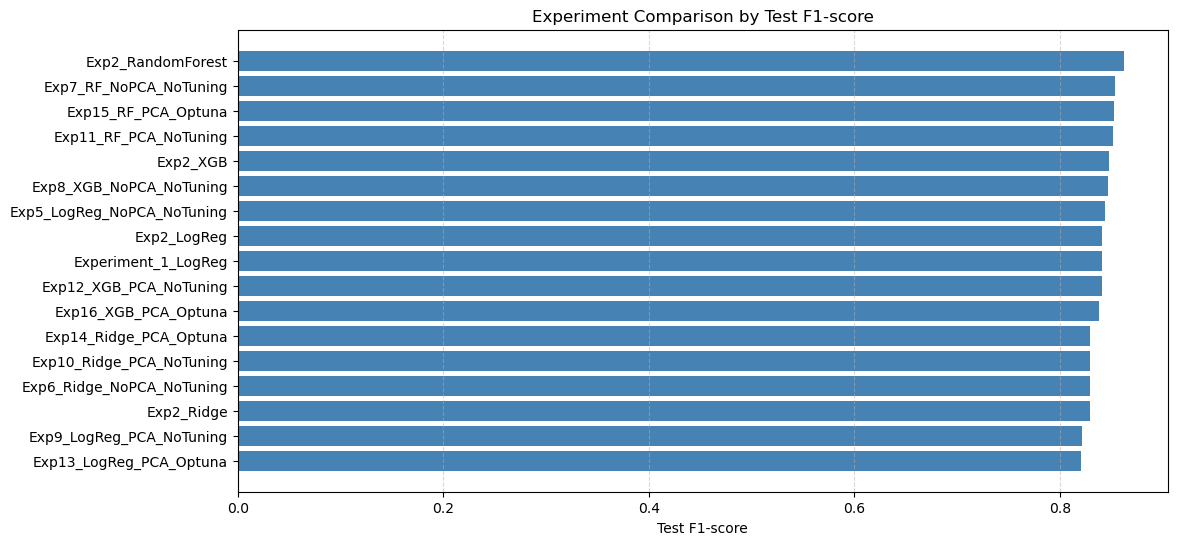

✅ Best Model: Exp2_RandomForest
✅ Test F1: 0.8619528619528619


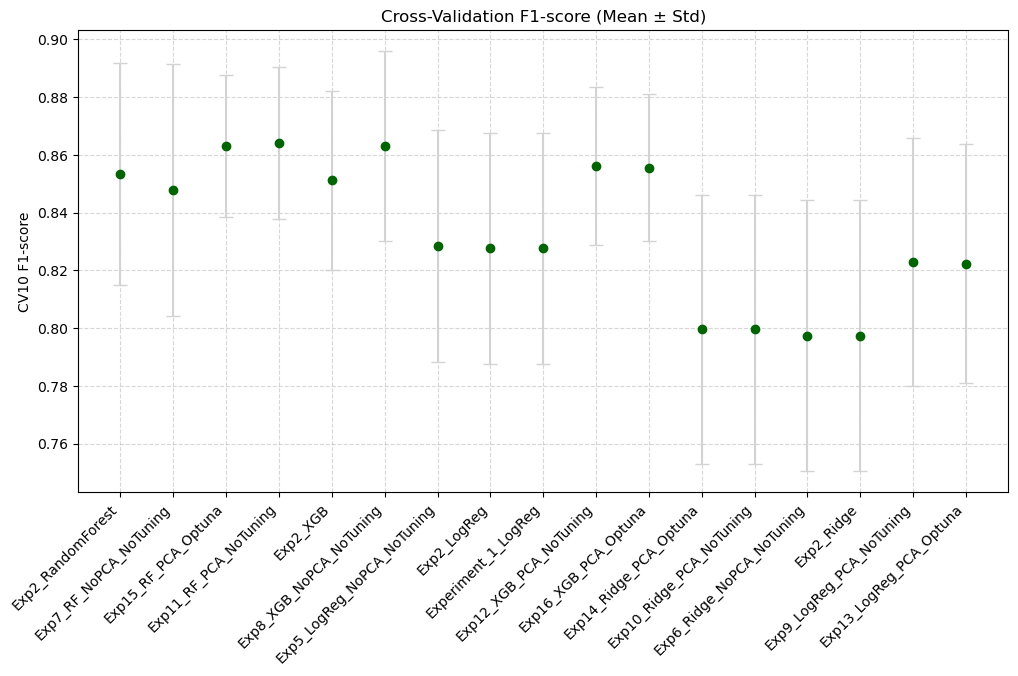

In [15]:
# ---------------------------------------------------------
# Model selection
# ---------------------------------------------------------

from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt

client = MlflowClient()
experiment = client.get_experiment_by_name("Avoidable_ED_Project_Experiments")
experiment_id = experiment.experiment_id

runs = client.search_runs(experiment_ids=[experiment_id])

records = []

for run in runs:
    run_id = run.info.run_id
    name = run.data.tags.get("mlflow.runName", run_id)

    test_f1 = run.data.metrics.get("test_f1")
    cv_mean = run.data.metrics.get("cv10_f1_mean")
    cv_std = run.data.metrics.get("cv10_f1_std")

    records.append({
        "run_name": name,
        "test_f1": test_f1,
        "cv10_f1_mean": cv_mean,
        "cv10_f1_std": cv_std,
        "run_id": run_id
    })

df_results = pd.DataFrame(records)
df_results = df_results.sort_values("test_f1", ascending=False)

df_results


plt.figure(figsize=(12, 6))
plt.barh(df_results["run_name"], df_results["test_f1"], color="steelblue")
plt.xlabel("Test F1-score")
plt.title("Experiment Comparison by Test F1-score")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()



best_row = df_results.iloc[0]
print("✅ Best Model:", best_row["run_name"])
print("✅ Test F1:", best_row["test_f1"])



plt.figure(figsize=(12, 6))
plt.errorbar(
    df_results["run_name"],
    df_results["cv10_f1_mean"],
    yerr=df_results["cv10_f1_std"],
    fmt="o",
    color="darkgreen",
    ecolor="lightgray",
    capsize=5
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CV10 F1-score")
plt.title("Cross-Validation F1-score (Mean ± Std)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()




# evaluated multiple models and preprocessing strategies across all experiments. 
# bar chart shows that RandomForest (Exp2) achieved the highest test F1-score, 
